## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
from sklearn import tree

# For tuning the model
from sklearn.model_selection import GridSearchCV

## To ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

## Load Data

In [2]:
df_raw = pd.read_csv('./data/train.csv')
df_raw_submit = pd.read_csv('./data/test.csv')

## Basic Info in Dataset

In [3]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Checking unique values in each column
df_raw.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

## Drop Unnecessary Columns

In [5]:
# Dropping the columns 

## TODO - would be better to keep cabin as a categorical variable 
 ## based on the geometry of the actual boat
dropcols = ['PassengerId','Name','Ticket', 'Embarked', 'Cabin']
df_filtered=df_raw.drop(dropcols,axis=1)
df_filtered_submit=df_raw_submit.drop(dropcols,axis=1)

In [6]:
## Split into Numerical / Categorical Columns
cols_num = ['Age', 'SibSp', 'Parch', 'Fare']
cols_cat = ['Survived', 'Pclass', 'Sex']

In [7]:
## Exploratory Analysis and Preprocessing

In [11]:
# Checking summary statistics
df_filtered[cols_num].describe().T
#df_filtered_submit[cols_num].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


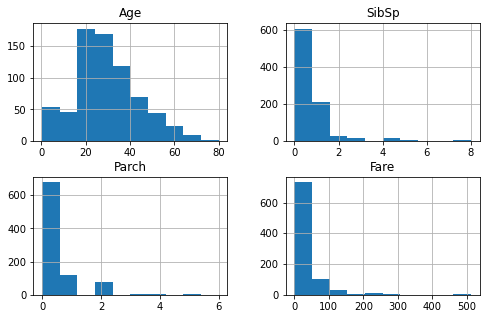

In [12]:
# Creating histograms
df_filtered[cols_num].hist(figsize=(8,5))
plt.show()

In [13]:
# Printing the % sub categories of each category
for i in cols_cat:
    print(df_filtered[i].value_counts(normalize=True))
    print('*'*40)

0    0.616162
1    0.383838
Name: Survived, dtype: float64
****************************************
3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64
****************************************
male      0.647587
female    0.352413
Name: Sex, dtype: float64
****************************************


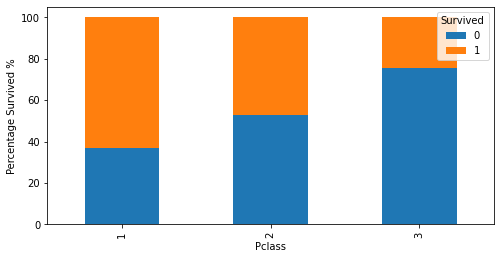

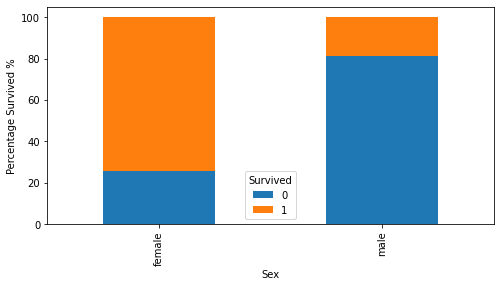

In [14]:
for i in cols_cat:
    if i!='Survived':
        (pd.crosstab(df_filtered[i],df_filtered['Survived'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Survived %')

In [15]:
# Mean of numerical variables grouped by attrition
df_filtered.groupby(['Survived'])[cols_num].mean()

,Age,SibSp,Parch,Fare
Survived,,,,
0,30.626179,0.553734,0.329690,22.117887
1,28.343690,0.473684,0.464912,48.395408


<AxesSubplot:>

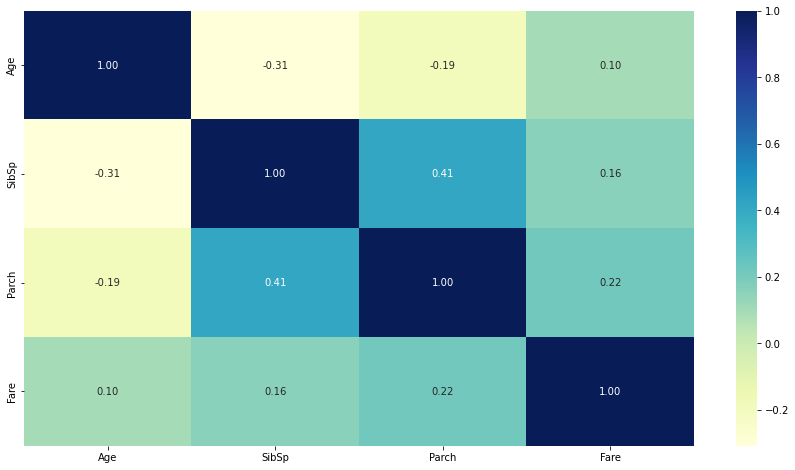

In [16]:
# Plotting the correlation between numerical variables
plt.figure(figsize=(15,8))
sns.heatmap(df_filtered[cols_num].corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

# Data Preparation

In [ ]:
df_filtered.info()

In [17]:
## Map female=1, male=0
dict_sex = {'female': 1, 'male': 0, 1:1, 0:0}
df_filtered['Sex'] = df_filtered.Sex.map(dict_sex)
df_filtered_submit['Sex'] = df_filtered_submit.Sex.map(dict_sex)

In [18]:
df_filtered.fillna(df_filtered.mean(), inplace=True)
df_filtered_submit.fillna(df_filtered.mean(), inplace=True)

In [19]:
df_filtered.info()
df_filtered_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    int64  
 2   Age     418 non-null    float64
 3   SibSp   418 non-null    int64  
 4   Parch   418 non-null    int64  
 5   Fare    418 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


In [20]:
# Separating target variable and other variables
Y= df_filtered.Survived
X= df_filtered.drop(columns = ['Survived'])
X_submit = df_filtered_submit

In [23]:
print(X.shape)
print(X_submit.shape)

(891, 6)
(418, 6)


In [24]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = Y)

In [25]:
# Scaling the data
sc=StandardScaler()

# Fit_transform on train data
X_train_scaled=sc.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X.columns)

# Transform on test data
X_test_scaled=sc.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X.columns)

# Transform submit data
X_submit_scaled=sc.transform(X_submit)
X_submit_scaled=pd.DataFrame(X_submit_scaled, columns=X.columns)

## Create a Metric Evaluation Function

In [26]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Survive', 'Survive'], yticklabels=['Not Survive', 'Survive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Logistic Regression

In [27]:
# Fitting logistic regression model
lg=LogisticRegression()
lg.fit(X_train_scaled,y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       384
           1       0.76      0.73      0.75       239

    accuracy                           0.81       623
   macro avg       0.80      0.79      0.80       623
weighted avg       0.81      0.81      0.81       623



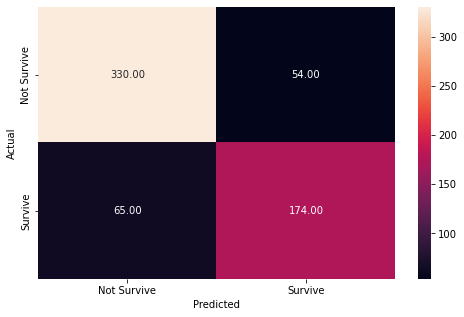

In [28]:
# Checking the performance on the training data
y_pred_train = lg.predict(X_train_scaled)
metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       165
           1       0.73      0.67      0.70       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268



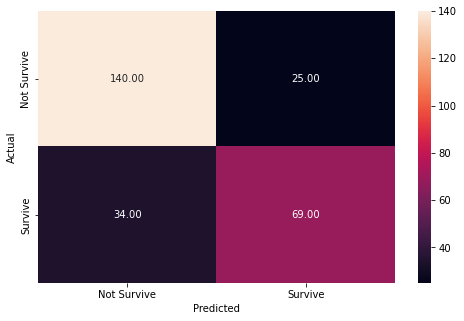

In [29]:
# Checking the performance on the test dataset
y_pred_test = lg.predict(X_test_scaled)
metrics_score(y_test, y_pred_test)

In [30]:
y_pred_submit_lg = lg.predict(X_submit_scaled)

In [31]:
# Printing the coefficients of logistic regression
cols=X.columns
coef_lg=lg.coef_
pd.DataFrame(coef_lg,columns=cols).T.sort_values(by = 0,ascending = False)

,0
Sex,1.327150
Fare,0.143927
Parch,-0.129850
SibSp,-0.496155
Age,-0.595056
Pclass,-0.958511


In [32]:
# Finding the odds
odds = np.exp(lg.coef_[0]) 

# Adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X_train_scaled.columns, columns = ['odds']).sort_values(by ='odds', ascending = False) 

,odds
Sex,3.770282
Fare,1.154800
Parch,0.878227
SibSp,0.608867
Age,0.551531
Pclass,0.383464


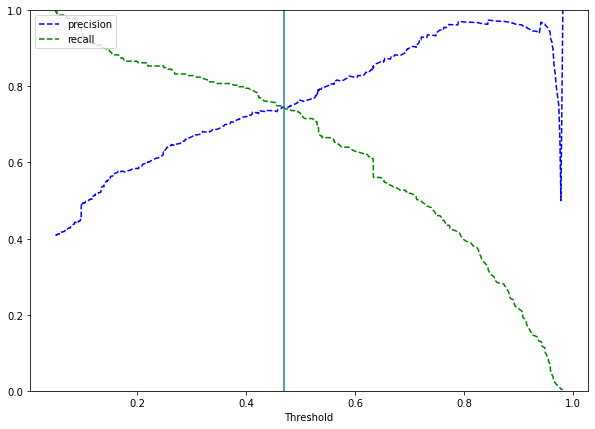

In [33]:
# Predict_proba gives the probability of each observation belonging to each class
y_scores_lg=lg.predict_proba(X_train_scaled)

precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:,1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])

plt.axvline(0.47)
plt.show()


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       384
           1       0.74      0.74      0.74       239

    accuracy                           0.80       623
   macro avg       0.79      0.79      0.79       623
weighted avg       0.80      0.80      0.80       623



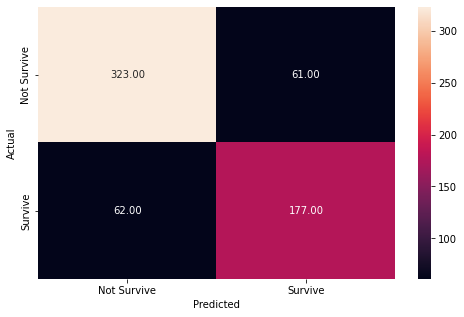

In [34]:
optimal_threshold=.47
y_pred_train = lg.predict_proba(X_train_scaled)

metrics_score(y_train, y_pred_train[:,1]>optimal_threshold)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       165
           1       0.74      0.68      0.71       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268



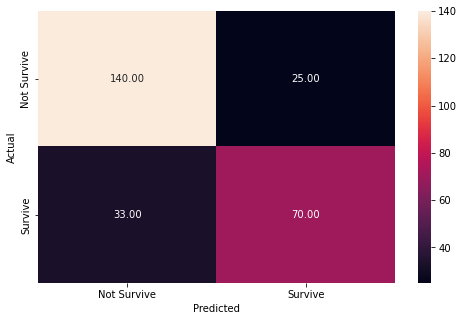

In [35]:
y_pred_test = lg.predict_proba(X_test_scaled)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold)

# Support Vector Machine

## Linear Kernel

In [36]:
# Fitting SVM
svm = SVC(kernel='linear') # Linear kernal or linear decision boundary
model = svm.fit(X= X_train_scaled, y = y_train)

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       384
           1       0.75      0.68      0.71       239

    accuracy                           0.79       623
   macro avg       0.78      0.77      0.78       623
weighted avg       0.79      0.79      0.79       623



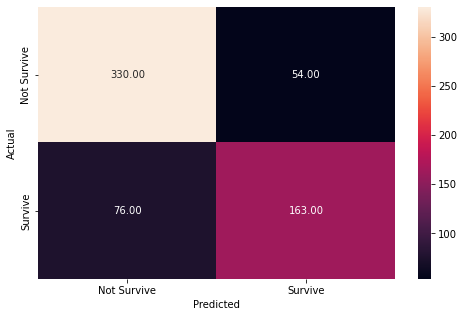

In [37]:
y_pred_train_svm = model.predict(X_train_scaled)
metrics_score(y_train, y_pred_train_svm)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       165
           1       0.77      0.69      0.73       103

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268



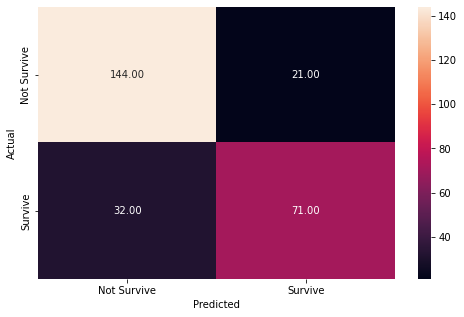

In [38]:
# Checking performance on the test data
y_pred_test_svm = model.predict(X_test_scaled)
metrics_score(y_test, y_pred_test_svm)

In [39]:
y_pred_submit_svm = model.predict(X_submit_scaled)

## RBF Kernel

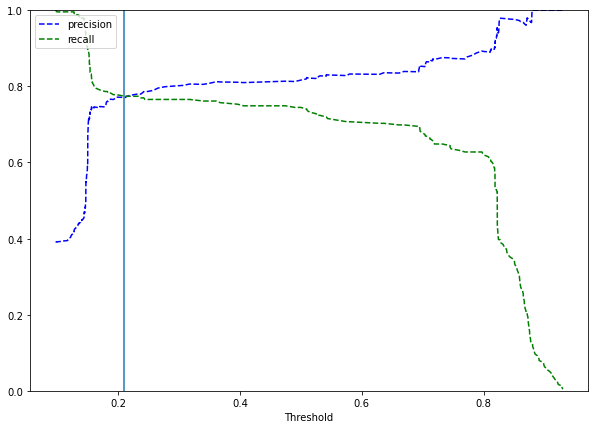

In [40]:
svm_rbf=SVC(kernel='rbf',probability=True)
# Fit the model
svm_rbf.fit(X_train_scaled,y_train)
# Predict on train data
y_scores_svm=svm_rbf.predict_proba(X_train_scaled)

precisions_svm, recalls_svm, thresholds_svm = precision_recall_curve(y_train, y_scores_svm[:,1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_svm, precisions_svm[:-1], 'b--', label='precision')
plt.plot(thresholds_svm, recalls_svm[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.axvline(0.21)
plt.show()

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       384
           1       0.77      0.77      0.77       239

    accuracy                           0.83       623
   macro avg       0.81      0.82      0.82       623
weighted avg       0.83      0.83      0.83       623



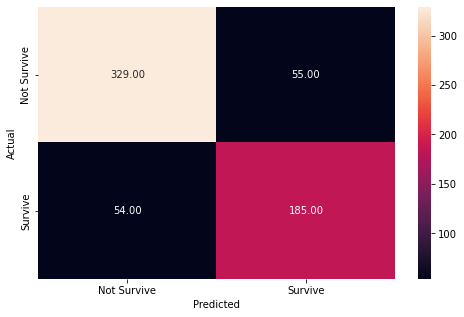

In [41]:
optimal_threshold_svm=.21
y_pred_train = svm_rbf.predict_proba(X_train_scaled)
metrics_score(y_train, y_pred_train[:,1]>optimal_threshold_svm)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       165
           1       0.77      0.70      0.73       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.81      0.80       268



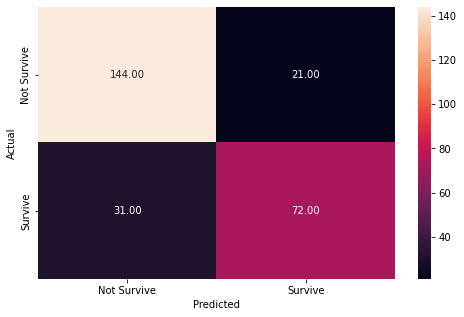

In [42]:
y_pred_test = svm_rbf.predict_proba(X_test_scaled)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold_svm)

In [56]:
y_pred_submit_svmrbf_rawoutput = svm_rbf.predict_proba(X_submit_scaled)
y_pred_submit_svmrbf = (y_pred_submit_svmrbf_rawoutput[:,1]>optimal_threshold_svm).astype(int)

In [57]:
print(y_pred_submit_svmrbf.shape)
print(y_pred_submit_svmrbf)
#print(y_pred_submit_svmrbf[:,1]>optimal_threshold_svm)

(418,)
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


# Decision Tree

In [58]:
# Building decision tree model
#dt = DecisionTreeClassifier(class_weight = {0: 0.17, 1: 0.83}, random_state = 1)
dt = DecisionTreeClassifier(random_state = 1)

In [59]:
# Fitting decision tree model
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       384
           1       1.00      0.97      0.98       239

    accuracy                           0.99       623
   macro avg       0.99      0.98      0.98       623
weighted avg       0.99      0.99      0.99       623



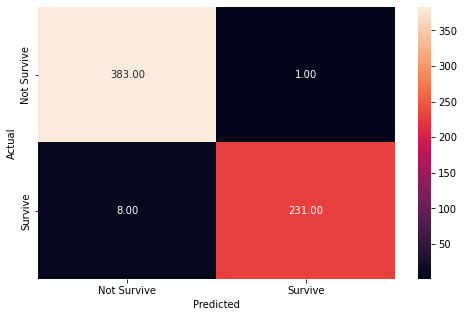

In [60]:
# Checking performance on the training dataset
y_train_pred_dt = dt.predict(X_train)
metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       165
           1       0.72      0.70      0.71       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268



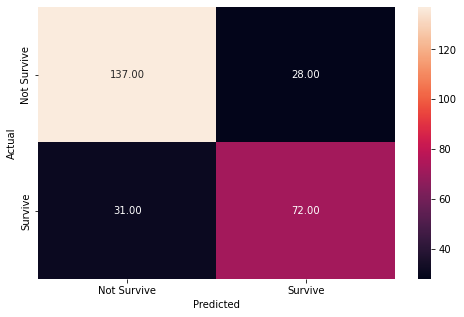

In [61]:
# Checking performance on the test dataset
y_test_pred_dt = dt.predict(X_test)
metrics_score(y_test, y_test_pred_dt)

In [63]:
# For Submit
y_pred_submit_dt = dt.predict(X_submit)

/Users/brittanyadam/opt/anaconda3/envs/tensorflow_environment/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Importance'>

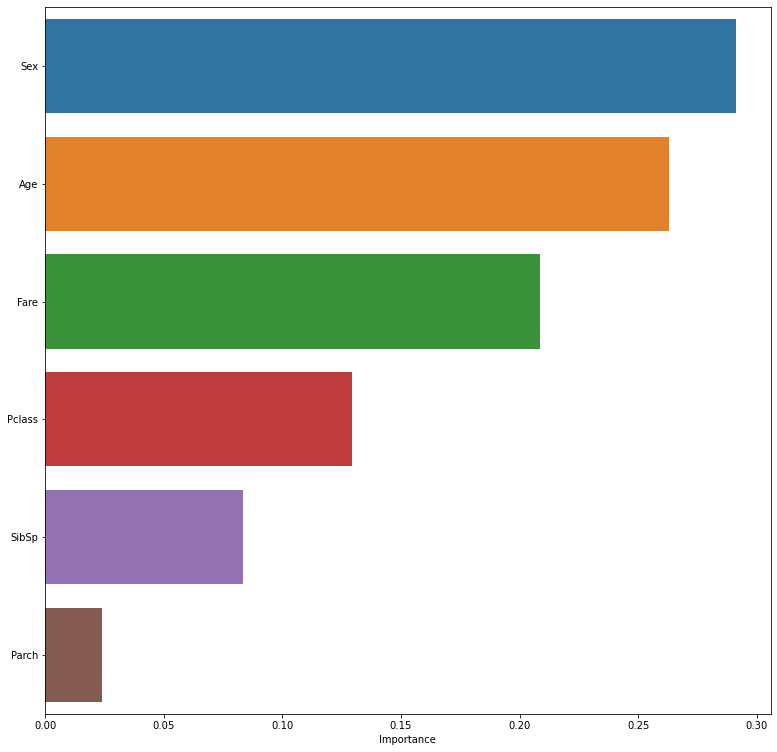

In [64]:
# Plot the feature importance
importances = dt.feature_importances_
columns = X.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (13, 13))
sns.barplot(importance_df.Importance,importance_df.index)

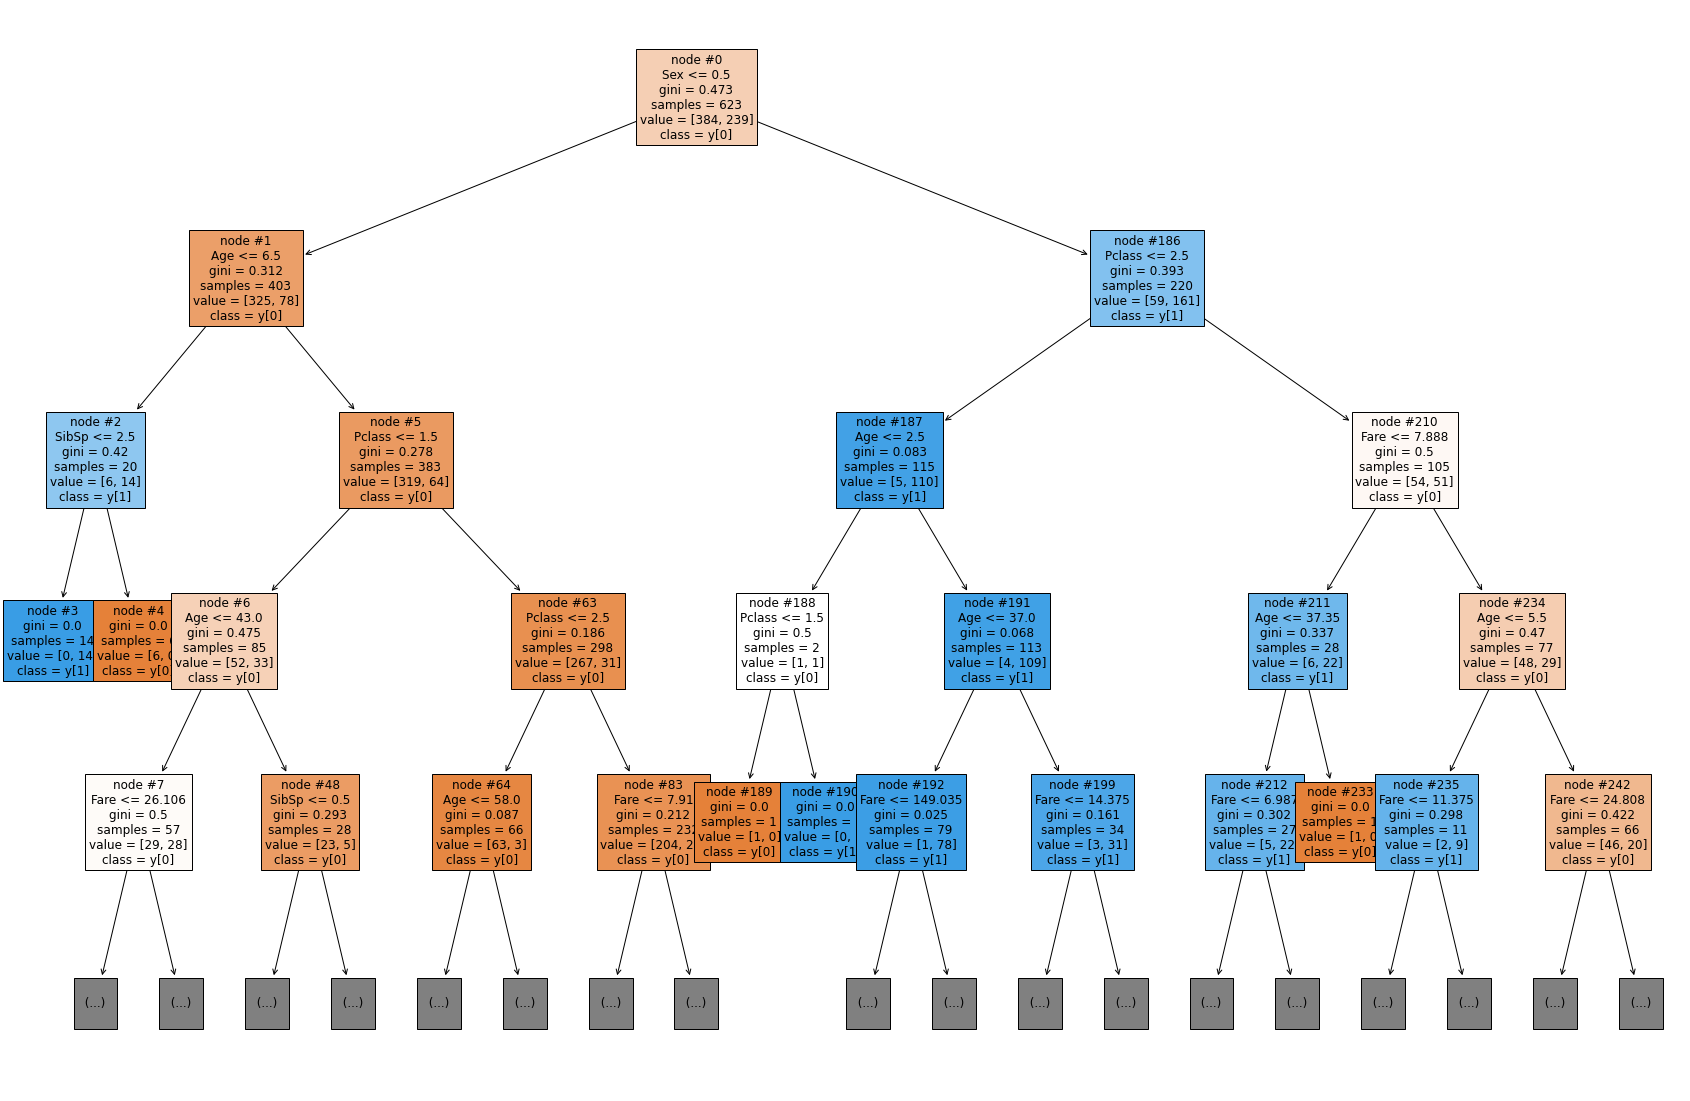

In [65]:
features = list(X.columns)
plt.figure(figsize = (30, 20))
tree.plot_tree(dt, max_depth = 4, feature_names = features, filled = True, fontsize = 12, node_ids = True, class_names = True)
plt.show()

# Random Forest

In [66]:
# Fitting the Random Forest classifier on the training data
#rf_estimator = RandomForestClassifier(class_weight = {0: 0.17, 1: 0.83}, random_state = 1)
rf_estimator = RandomForestClassifier(random_state = 1)
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       384
           1       1.00      0.97      0.98       239

    accuracy                           0.99       623
   macro avg       0.99      0.98      0.98       623
weighted avg       0.99      0.99      0.99       623



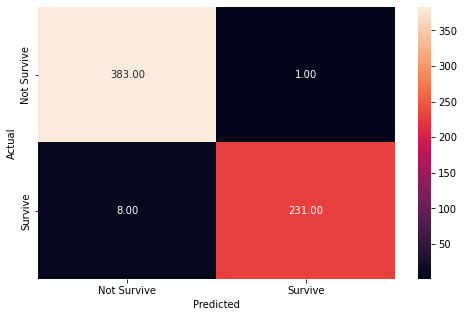

In [67]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(X_train)
metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       165
           1       0.77      0.72      0.74       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



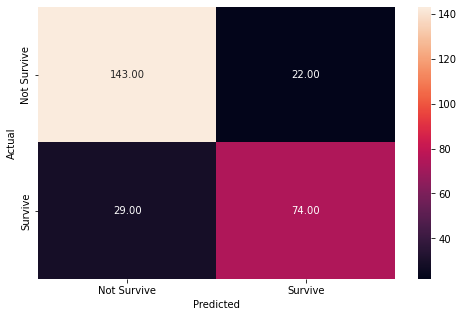

In [68]:
# Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(X_test)
metrics_score(y_test, y_pred_test_rf)

In [69]:
y_pred_submit_rf = rf_estimator.predict(X_submit)

# Look at the predictions

In [73]:
#y_pred_submit_lg ## Logistic Regression
#y_pred_submit_svm  ## Linear Support Vector Machine
#y_pred_submit_svmrbf ## RBF Support Vector Machine
#y_pred_submit_dt   ## Decision Tree
#y_pred_submit_rf   ## Random Forest

dict_predictions = {
 "logreg": y_pred_submit_lg, ## Logistic Regression
 "linsvm": y_pred_submit_svm,  ## Linear Support Vector Machine
 "rbfsvm": y_pred_submit_svmrbf, ## RBF Support Vector Machine
 "dtree" : y_pred_submit_dt,   ## Decision Tree
 "forest": y_pred_submit_rf,   ## Random Forest
}

#for k in dict_predictions:
#    print(np.shape(dict_predictions[k]))
#    print(k)
#    print(dict_predictions[k])

In [74]:
pdf_predictions = pd.DataFrame(dict_predictions)

In [84]:
pdf_predictions['final_prediction_a'] = \
 pdf_predictions[["logreg","linsvm","rbfsvm","dtree","forest"]].median(axis=1).astype(int)

In [85]:
pdf_predictions.head()

,logreg,linsvm,rbfsvm,dtree,forest,final_prediction_a
0,0,0,0,0,0,0
1,0,1,1,0,0,0
2,0,0,0,1,1,0
3,0,0,0,1,1,0
4,1,1,1,0,0,1
